# Diffusion Process 입출력 시각화

## Diffusion 구조
- **Forward Process (q_sample)**: 이미지에 노이즈 추가
- **Reverse Process (p_sample_loop)**: 노이즈에서 이미지 복원

## 주요 메서드
1. **q_sample(x_start, t, noise)**: 노이즈 추가 (학습용)
   - 입력: x_start (B, 4, 28, 28), t (timestep), noise
   - 출력: x_t (B, 4, 28, 28) - 노이즈가 추가된 latent

2. **p_sample_loop(model, shape, ...)**: 노이즈 제거 (추론용)
   - 입력: model, shape, noise (random latent)
   - 출력: denoised latent (B, 4, 28, 28)

3. **training_losses(model, x_start, t, ...)**: 학습 loss 계산
   - 입력: model, x_start, t, model_kwargs
   - 출력: dict with 'loss', 'mse', etc.

## 1. Import 및 헬퍼 함수

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers.models import AutoencoderKL
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

from diffusion import create_diffusion

%matplotlib inline

In [3]:
def load_image_from_url(url, image_size=224):
    """URL에서 이미지 로드 및 전처리"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    _transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return _transform(img).unsqueeze(0), img


def tensor_to_image(tensor):
    """텐서를 이미지로 변환 ([-1, 1] -> [0, 255])"""
    img = (tensor * 0.5 + 0.5).clamp(0, 1)
    img = img.permute(0, 2, 3, 1).cpu().numpy()
    return (img * 255).astype(np.uint8)


def visualize_latent_single(latent, ax, title=""):
    """단일 latent를 평균으로 시각화"""
    latent_np = latent[0].mean(dim=0).cpu().numpy()
    im = ax.imshow(latent_np, cmap='viridis')
    ax.set_title(title, fontsize=9)
    ax.axis('off')
    return im

## 2. VAE 및 Diffusion 모델 로드

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# VAE 로드
print("Loading VAE...")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device)
vae = AutoencoderKL.from_pretrained("logs/sd-vae-ft-ema").to(device)
vae.eval()
print("VAE loaded!")

# Diffusion 생성
print("\nCreating Diffusion (250 steps)...")
diffusion = create_diffusion(str(250))
print("Diffusion created!")

Using device: cuda
Loading VAE...
VAE loaded!

Creating Diffusion (250 steps)...
Diffusion created!


## 3. Diffusion 설정 확인

In [5]:
print("="*60)
print("DIFFUSION CONFIG")
print("="*60)
print(f"Number of timesteps: {diffusion.num_timesteps}")
print(f"Model mean type: {diffusion.model_mean_type}")
print(f"Model var type: {diffusion.model_var_type}")
print(f"Loss type: {diffusion.loss_type}")

DIFFUSION CONFIG
Number of timesteps: 250
Model mean type: ModelMeanType.EPSILON
Model var type: ModelVarType.LEARNED_RANGE
Loss type: LossType.MSE


## 4. 샘플 이미지 로드 및 Latent 인코딩

Loading image from: https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png


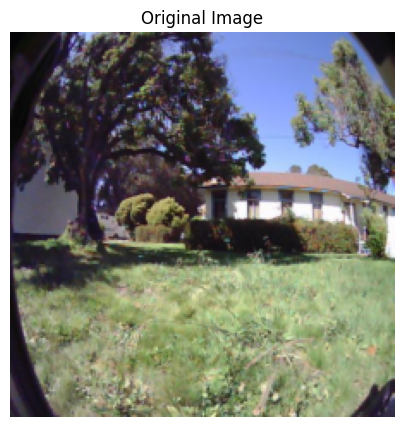


Original image shape: torch.Size([1, 3, 224, 224])
Latent shape: torch.Size([1, 4, 28, 28])
Latent range: [-2.697, 4.356]


In [6]:
url = 'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png'
print(f"Loading image from: {url}")
x_pixel, original_pil = load_image_from_url(url)
x_pixel = x_pixel.to(device)

# 원본 이미지 표시
plt.figure(figsize=(5, 5))
plt.imshow(original_pil)
plt.title("Original Image")
plt.axis('off')
plt.show()

# VAE 인코딩
with torch.no_grad():
    x_latent = vae.encode(x_pixel).latent_dist.sample() * 0.18215

print(f"\nOriginal image shape: {x_pixel.shape}")
print(f"Latent shape: {x_latent.shape}")
print(f"Latent range: [{x_latent.min().item():.3f}, {x_latent.max().item():.3f}]")

## 5. Forward Process (q_sample): 노이즈 추가

Forward diffusion 공식:
$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$

In [7]:
print("="*60)
print("FORWARD PROCESS: q_sample")
print("="*60)
print("x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise")
print()

timesteps = [0, 50, 100, 150, 200, 249]
noisy_latents = []
noise = torch.randn_like(x_latent)

print(f"Input x_start shape: {x_latent.shape}")
print(f"Noise shape: {noise.shape}")
print()

for t_val in timesteps:
    t = torch.tensor([t_val], device=device)
    x_t = diffusion.q_sample(x_latent, t, noise=noise)
    noisy_latents.append(x_t)
    print(f"t={t_val:3d}: x_t range [{x_t.min().item():.3f}, {x_t.max().item():.3f}]")

FORWARD PROCESS: q_sample
x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise

Input x_start shape: torch.Size([1, 4, 28, 28])
Noise shape: torch.Size([1, 4, 28, 28])

t=  0: x_t range [-2.702, 4.367]
t= 50: x_t range [-2.836, 4.182]
t=100: x_t range [-3.186, 2.916]
t=150: x_t range [-3.449, 3.135]
t=200: x_t range [-3.573, 3.153]
t=249: x_t range [-3.598, 3.149]


## 6. Forward Process 시각화

Saved: diffusion_forward_process.png


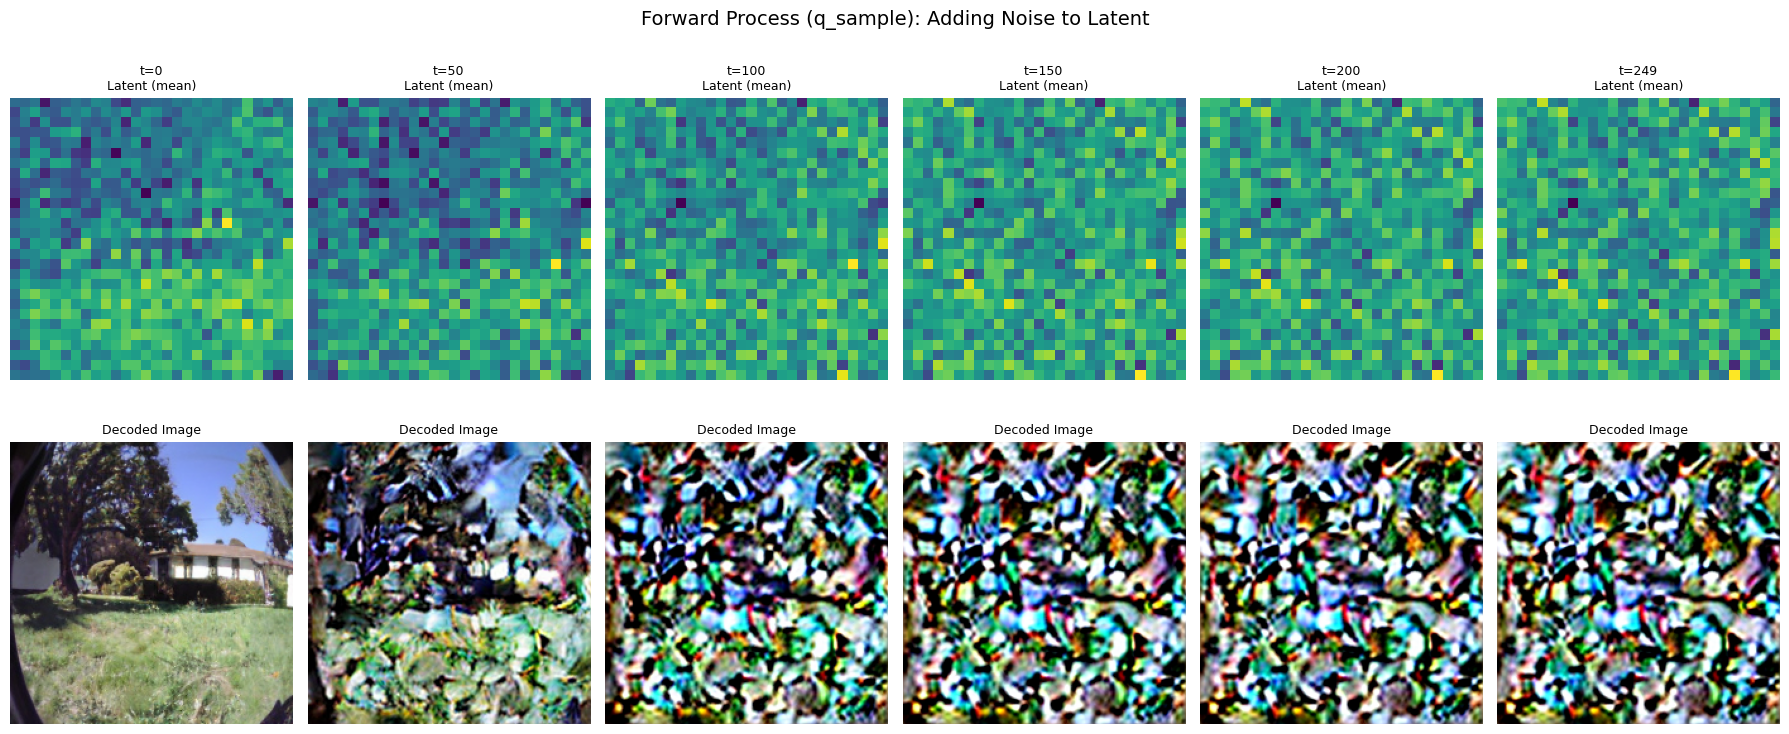

In [8]:
fig, axes = plt.subplots(2, len(timesteps), figsize=(18, 8))
fig.suptitle("Forward Process (q_sample): Adding Noise to Latent", fontsize=14)

for i, (t_val, x_t) in enumerate(zip(timesteps, noisy_latents)):
    # Latent 시각화 (평균)
    visualize_latent_single(x_t, axes[0, i], f"t={t_val}\nLatent (mean)")

    # VAE 디코딩하여 이미지로 시각화
    with torch.no_grad():
        decoded = vae.decode(x_t / 0.18215).sample
    img = tensor_to_image(decoded)[0]
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Decoded Image", fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('diffusion_forward_process.png', dpi=150, bbox_inches='tight')
print("Saved: diffusion_forward_process.png")
plt.show()

## 7. Noise Schedule 시각화

Saved: diffusion_noise_schedule.png


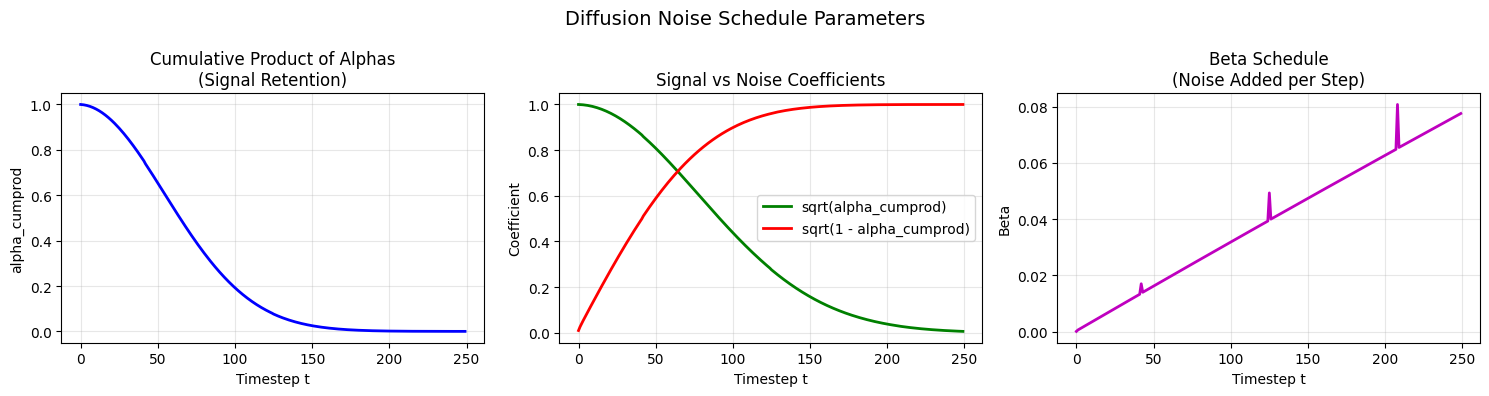

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Diffusion Noise Schedule Parameters", fontsize=14)

# Alpha cumprod
axes[0].plot(diffusion.alphas_cumprod, 'b-', linewidth=2)
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('alpha_cumprod')
axes[0].set_title('Cumulative Product of Alphas\n(Signal Retention)')
axes[0].grid(True, alpha=0.3)

# Sqrt alpha cumprod (signal coefficient)
axes[1].plot(diffusion.sqrt_alphas_cumprod, 'g-', linewidth=2, label='sqrt(alpha_cumprod)')
axes[1].plot(diffusion.sqrt_one_minus_alphas_cumprod, 'r-', linewidth=2, label='sqrt(1 - alpha_cumprod)')
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Signal vs Noise Coefficients')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Betas
axes[2].plot(diffusion.betas, 'm-', linewidth=2)
axes[2].set_xlabel('Timestep t')
axes[2].set_ylabel('Beta')
axes[2].set_title('Beta Schedule\n(Noise Added per Step)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diffusion_noise_schedule.png', dpi=150, bbox_inches='tight')
print("Saved: diffusion_noise_schedule.png")
plt.show()

## 8. Diffusion 요약

Saved: diffusion_summary.png


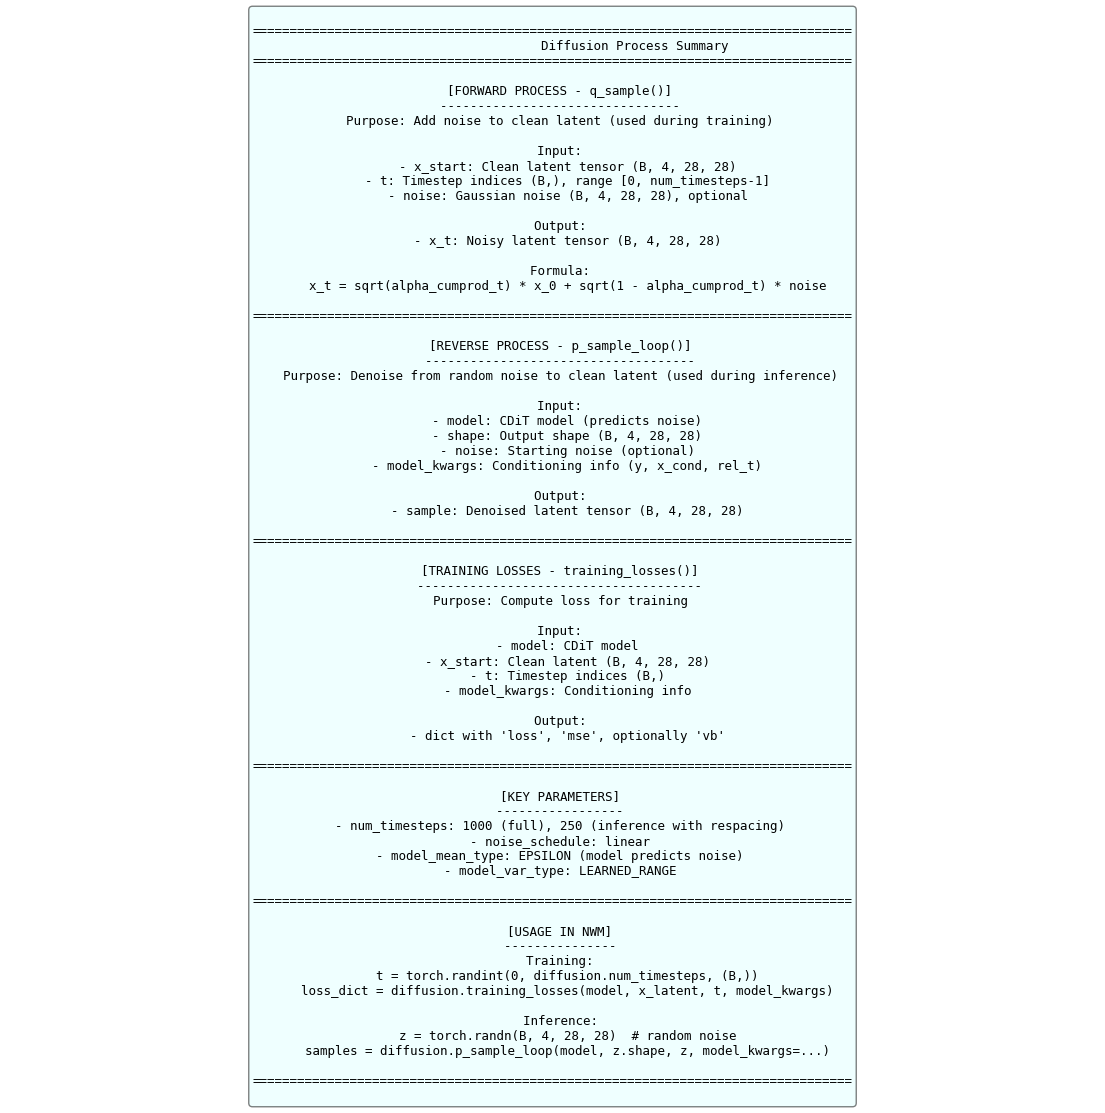


Done!


In [10]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')

summary_text = """
================================================================================
                      Diffusion Process Summary
================================================================================

  [FORWARD PROCESS - q_sample()]
  --------------------------------
  Purpose: Add noise to clean latent (used during training)

  Input:
    - x_start: Clean latent tensor (B, 4, 28, 28)
    - t: Timestep indices (B,), range [0, num_timesteps-1]
    - noise: Gaussian noise (B, 4, 28, 28), optional

  Output:
    - x_t: Noisy latent tensor (B, 4, 28, 28)

  Formula:
    x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise

================================================================================

  [REVERSE PROCESS - p_sample_loop()]
  ------------------------------------
  Purpose: Denoise from random noise to clean latent (used during inference)

  Input:
    - model: CDiT model (predicts noise)
    - shape: Output shape (B, 4, 28, 28)
    - noise: Starting noise (optional)
    - model_kwargs: Conditioning info (y, x_cond, rel_t)

  Output:
    - sample: Denoised latent tensor (B, 4, 28, 28)

================================================================================

  [TRAINING LOSSES - training_losses()]
  --------------------------------------
  Purpose: Compute loss for training

  Input:
    - model: CDiT model
    - x_start: Clean latent (B, 4, 28, 28)
    - t: Timestep indices (B,)
    - model_kwargs: Conditioning info

  Output:
    - dict with 'loss', 'mse', optionally 'vb'

================================================================================

  [KEY PARAMETERS]
  -----------------
  - num_timesteps: 1000 (full), 250 (inference with respacing)
  - noise_schedule: linear
  - model_mean_type: EPSILON (model predicts noise)
  - model_var_type: LEARNED_RANGE

================================================================================

  [USAGE IN NWM]
  ---------------
  Training:
    t = torch.randint(0, diffusion.num_timesteps, (B,))
    loss_dict = diffusion.training_losses(model, x_latent, t, model_kwargs)

  Inference:
    z = torch.randn(B, 4, 28, 28)  # random noise
    samples = diffusion.p_sample_loop(model, z.shape, z, model_kwargs=...)

================================================================================
"""

ax.text(0.5, 0.5, summary_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='center', horizontalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.5))

plt.savefig('diffusion_summary.png', dpi=150, bbox_inches='tight')
print("Saved: diffusion_summary.png")
plt.show()

print("\n" + "="*60)
print("Done!")
print("="*60)